## Case control - sklearn


In [22]:
import os

import rpy2.robjects as ro

In [23]:
ro.r('version')

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ValueError: Not an R object.

<rpy2.robjects.vectors.ListVector object at 0x000001D2934A6F90> [19]
R classes: ('simple.list',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'numpy.ndarray'>
  array(['x86_64-w64-mingw32'], dtype='<U18')
  arch: <class 'numpy.ndarray'>
  array(['x86_64'], dtype='<U6')
  os: <class 'numpy.ndarray'>
  array(['mingw32'], dtype='<U7')
  crt: <class 'numpy.ndarray'>
  array(['ucrt'], dtype='<U4')
...
  status: <class 'numpy.ndarray'>
  array(['87279'], dtype='<U5')
  major: <class 'numpy.ndarray'>
  array(['R'], dtype='<U1')
  minor: <class 'numpy.ndarray'>
  array(['R version 4.4.2 (2024-10-31 ucrt)'], dtype='<U33')
  year: <class 'numpy.ndarray'>
  array(['Pile of Leaves'], dtype='<U14')

In [24]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import t
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import cauchy
import scipy.stats as stats

In [25]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Activate automatic conversion between pandas DataFrame and R DataFrame
pandas2ri.activate()

In [26]:
n_individuals= 1000
n_simulations=1000

maf=0.2
alpha = 0.3 
gamma=0.5
beta=0.2

In [27]:
def simulate_genotypes(num_individuals, freq_ref):
    genotypes=[]
    for i in range(num_individuals):
        p_aa = freq_ref ** 2
        p_Aa = 2 * freq_ref * (1 - freq_ref)
        p_AA = (1 - freq_ref) ** 2
        
        gen = random.choices([2, 1, 0], weights=[p_aa, p_Aa, p_AA])[0]
        genotypes.append(gen)
    return genotypes

In [28]:
# def compute_p_value(X, y):
#     """Computes the p-value for the interaction coefficient in logistic regression."""
#     model = sm.Logit(y, X)  # Fit logistic model
#     result = model.fit(disp=0)  # Suppress output
#     p_values = result.pvalues  # Extract p-values
#     return p_values[-1]

In [29]:
def compute_p_value(X, y):
    model = LogisticRegression(fit_intercept=False, solver='lbfgs')
    model.fit(X, y)

    # Extract coefficients
    beta = model.coef_.flatten()

    # Compute Hessian matrix approximation
    pred_probs = model.predict_proba(X)[:, 1]  # Predicted probabilities
    W = np.diag(pred_probs * (1 - pred_probs))  # Weight matrix
    Hessian = X.T @ W @ X  # Hessian matrix
    cov_matrix = np.linalg.inv(Hessian)  # Covariance matrix

    # Compute standard error for interaction coefficient (last column in X)
    se_interaction = np.sqrt(np.diag(cov_matrix))[-1]

    # Compute z-score and p-value for interaction term
    z_score = beta[-1] / se_interaction
    p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))  # Two-tailed test

    return p_value

In [38]:
# def acat(pvals, weights=None):
#     pvals = np.array(pvals)
#     if np.any(pvals <= 0) or np.any(pvals >= 1):
#         raise ValueError("P-values must be between 0 and 1 (exclusive).")

#     if weights is None:
#         weights = np.ones(len(pvals))  # Equal weights if not provided

#     weights = np.array(weights) / np.sum(weights)  # Normalize weights
#     cauchy_transformed = np.tan(np.pi * (0.5 - pvals))  # Cauchy transformation

#     acat_statistic = np.sum(weights * cauchy_transformed)  # Weighted sum
#     p_acat = 1 - cauchy.cdf(acat_statistic)  # Convert back to p-value

#     return p_acat

In [39]:
ro.r('''
    library(ACAT)
    acat_calc <- function(p_values) {
        p_values <- as.matrix(p_values)  # Ensure matrix format
        acat_values <- apply(p_values, 1, function(x) ACAT(x))  # Compute ACAT row-wise
        return(as.vector(acat_values))  # Return a vector
    }
''')

acat_calc = ro.globalenv['acat_calc']

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



In [40]:
ro.r('''
    library(harmonicmeanp)
    hmp_calc <- function(p_values) {
        p_values <- as.matrix(p_values)  # Ensure matrix format
        hmp_values <- apply(p_values, 1, function(x) p.hmp(x, w = NULL))  # Compute HMP row-wise
        return(as.vector(hmp_values))  # Ensure it returns a vector
    }
''')
hmp_calc = ro.globalenv['hmp_calc']

In [41]:
alpha_values = [0.1, 0.2, 0.3]
beta_values = [0, 0.2, 0.4]

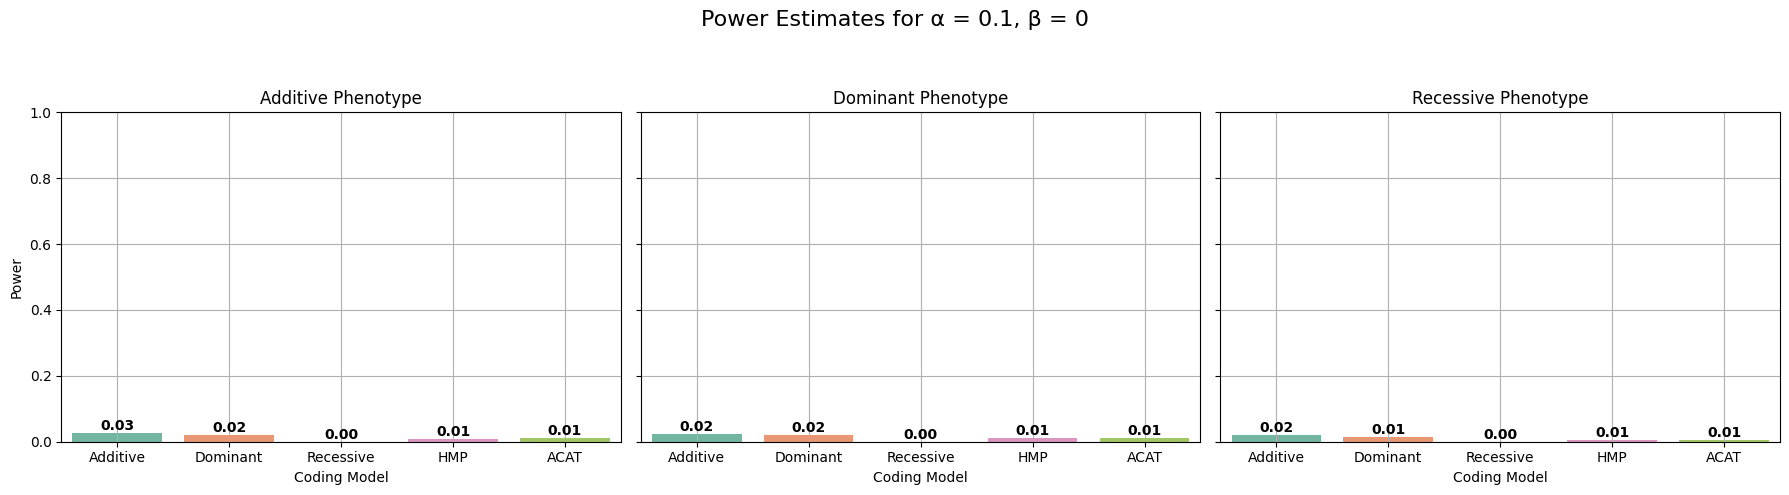

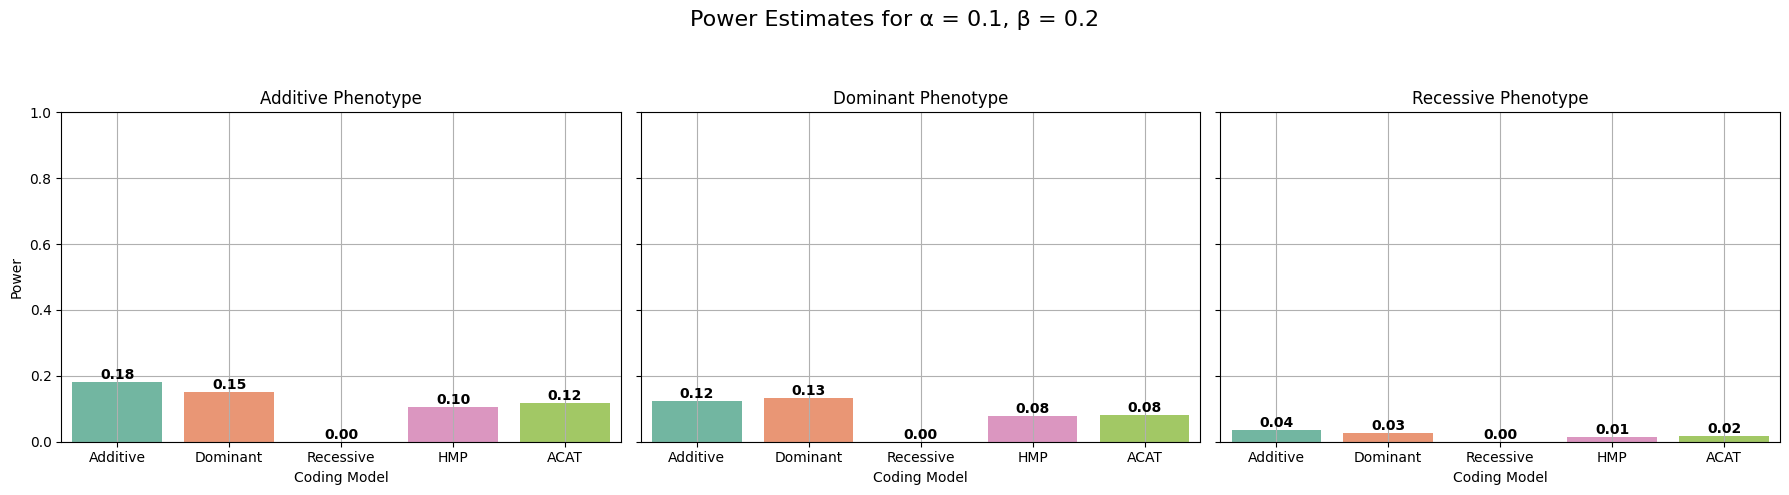

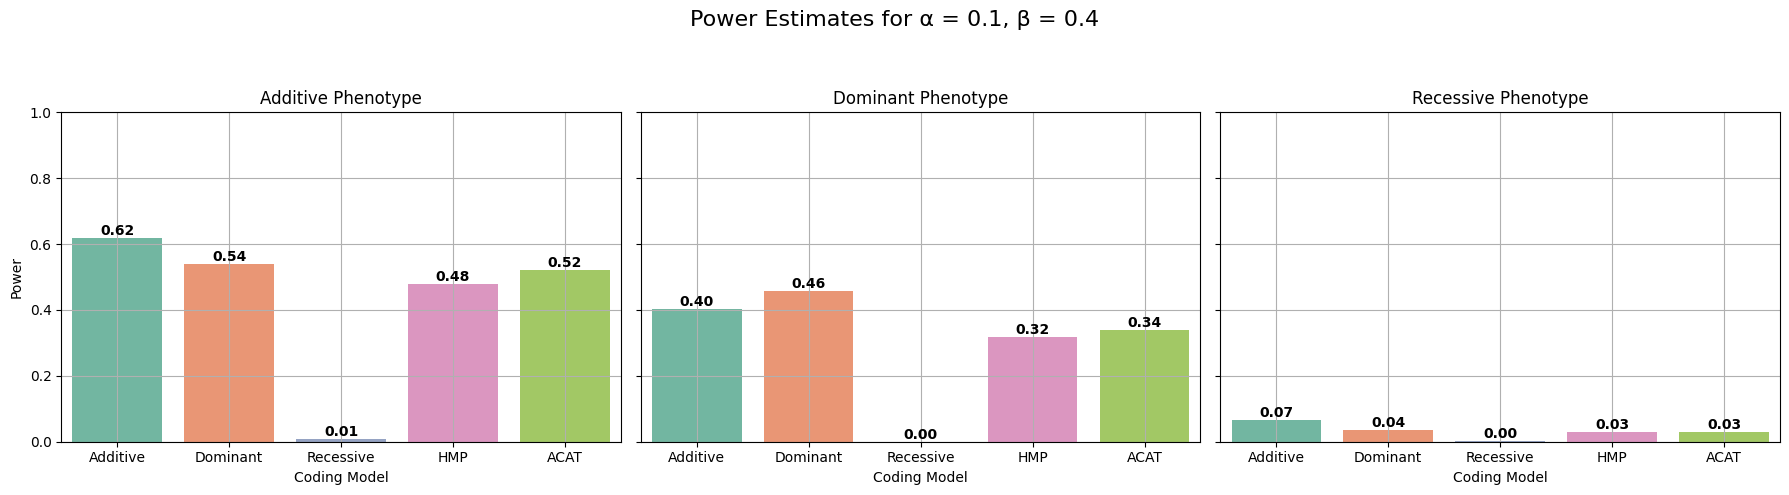

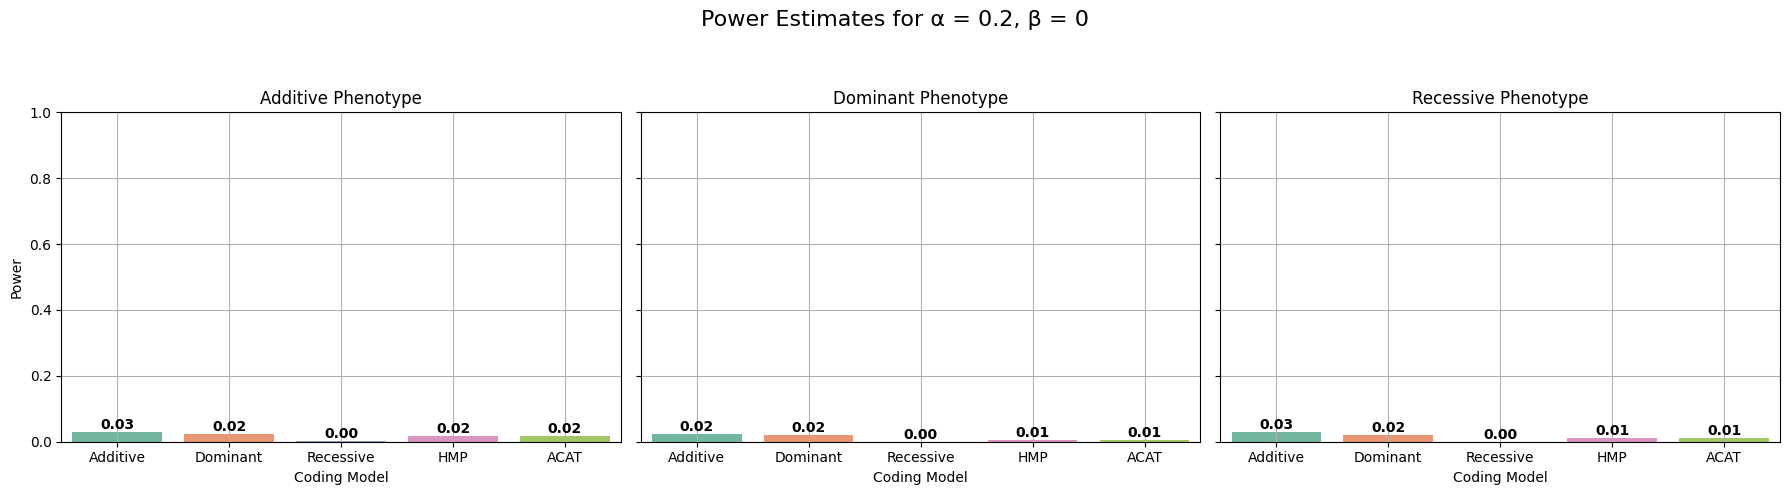

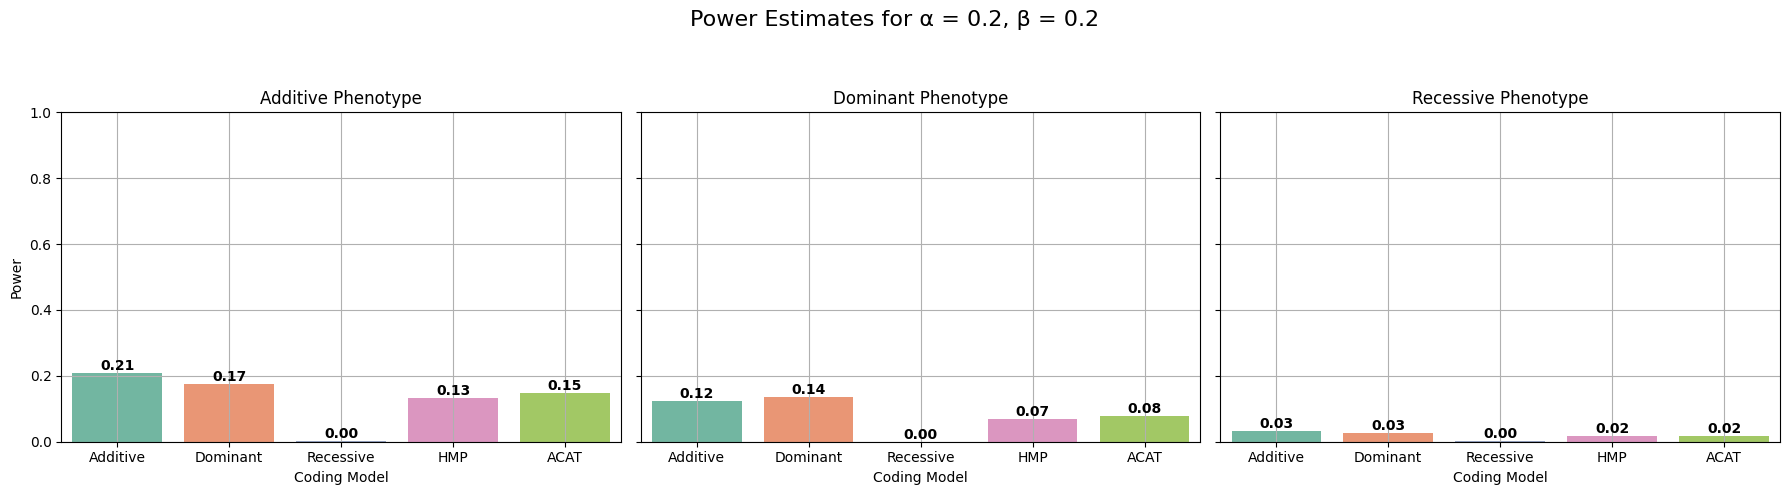

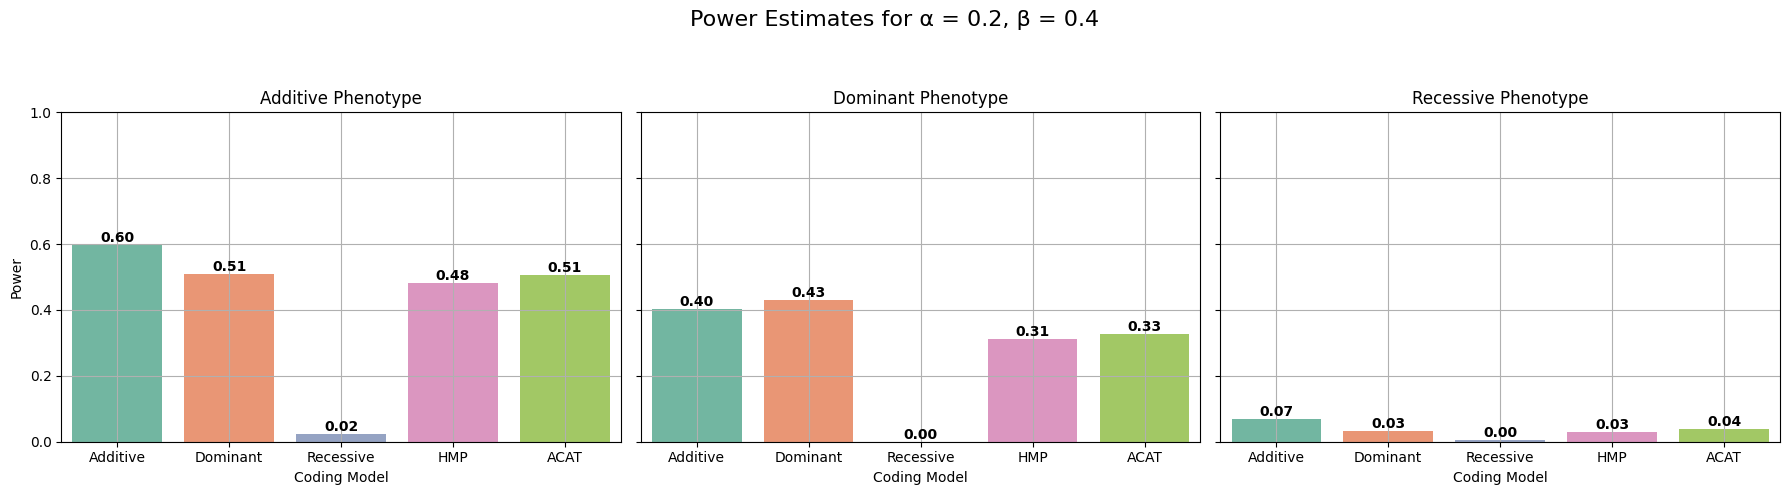

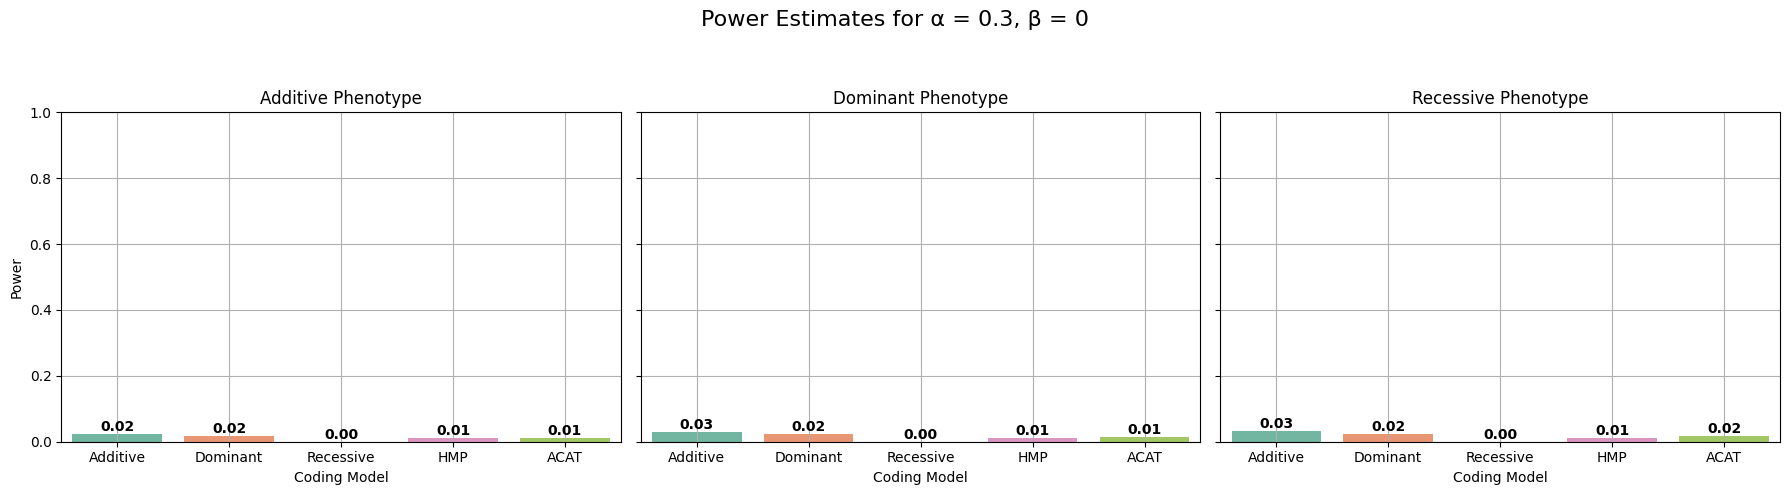

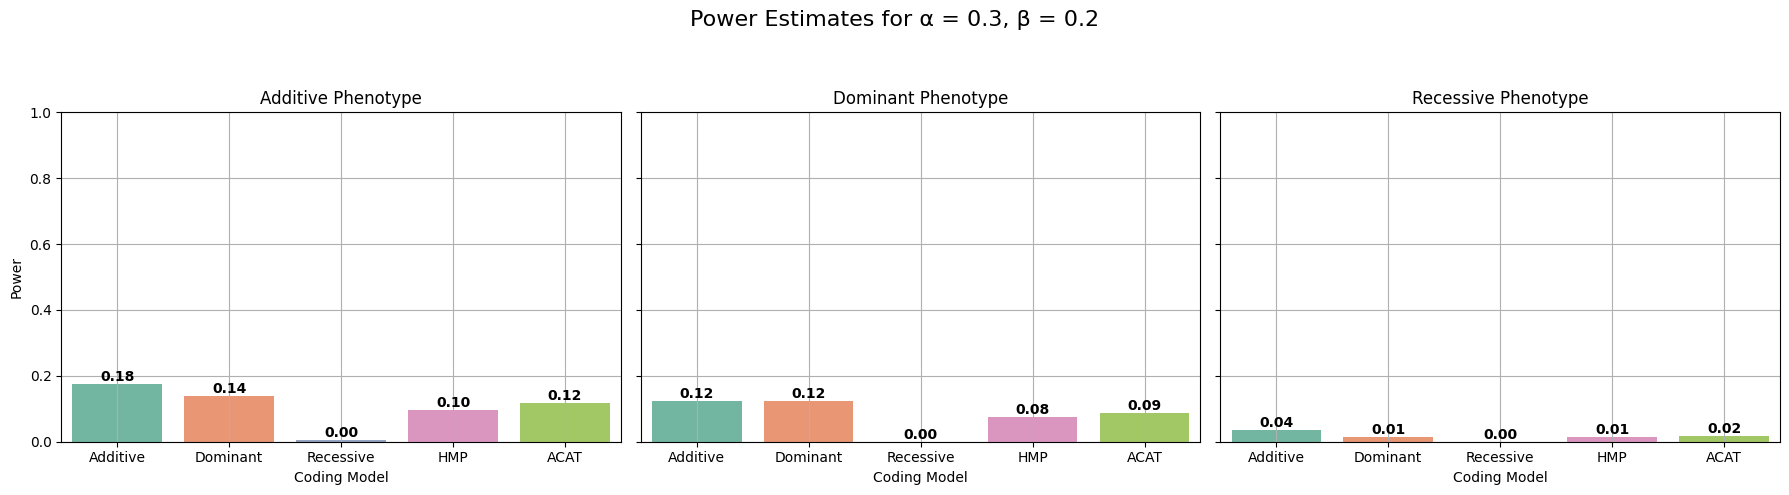

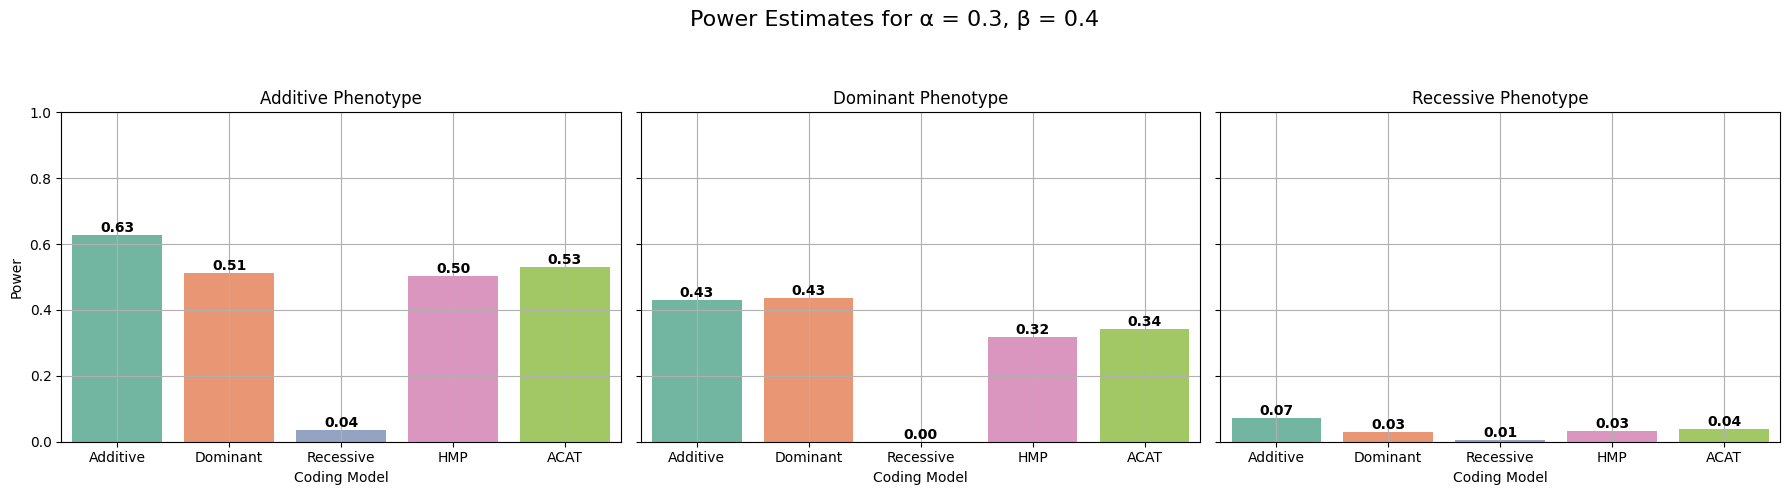

In [42]:
# Loop over each combination of α and β
for alpha in alpha_values:
    for beta in beta_values:
        # --- Initialize dictionaries to accumulate power for each phenotype type ---
        power_results_add = {"Additive": 0, "Dominant": 0, "Recessive": 0, "HMP": 0, 'ACAT': 0}
        power_results_dom = {"Additive": 0, "Dominant": 0, "Recessive": 0, "HMP": 0, 'ACAT': 0}
        power_results_rec = {"Additive": 0, "Dominant": 0, "Recessive": 0, "HMP": 0, 'ACAT': 0}
        
        # --- Simulation for Additive Phenotype ---
        for _ in range(n_simulations):
            df = pd.DataFrame()
            df['genotypes'] = simulate_genotypes(n_individuals, maf)
            df['exposure'] = np.random.binomial(1, 0.6, n_individuals)
            # Create alternative codings
            df['genotypes_dom'] = (df['genotypes'] > 0).astype(int)
            df['genotypes_rec'] = (df['genotypes'] == 2).astype(int)
            
            # Generate phenotype using additive model (raw genotype)
            df['phenotype'] = (alpha * df['genotypes'] +
                               gamma * df['exposure'] +
                               beta * (df['genotypes'] * df['exposure']) +
                               np.random.normal(0, 1, n_individuals))
            
            df = df.sort_values('phenotype', axis=0, ascending=False, ignore_index=True)
            threshold = df['phenotype'].quantile(0.8)
            df['case_control'] = (df['phenotype'] >= threshold).astype(int)

            # --- Fit OLS models for three genotype codings ---
            X_add = np.column_stack((np.ones(n_individuals),
                                      df['genotypes'],
                                      df['exposure'],
                                      df['genotypes'] * df['exposure']))
            
            p_val_add = compute_p_value(X_add,df['case_control'])
            
            X_dom = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_dom'],
                                      df['exposure'],
                                      df['genotypes_dom'] * df['exposure']))
           
            p_val_dom = compute_p_value(X_dom,df['case_control'])
            
            X_rec = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_rec'],
                                      df['exposure'],
                                      df['genotypes_rec'] * df['exposure']))
            
            p_val_rec = compute_p_value(X_rec,df['case_control'])
            
            power_results_add["Additive"] += (p_val_add < 0.05)
            power_results_add["Dominant"] += (p_val_dom < 0.05)
            power_results_add["Recessive"] += (p_val_rec < 0.05)
            
            # Compute HMP using the R function
            pvals_arr = np.array([[p_val_add, p_val_dom, p_val_rec]])
            r_matrix = ro.conversion.py2rpy(pvals_arr)
            hmp_val = list(hmp_calc(r_matrix))[0]
            power_results_add["HMP"] += (hmp_val < 0.05)

            acat_val = list(acat_calc(r_matrix))[0]
            power_results_add["ACAT"] += (acat_val < 0.05)
            
        # --- Simulation for Dominant Phenotype ---
        for _ in range(n_simulations):
            df = pd.DataFrame()
            df['genotypes'] = simulate_genotypes(n_individuals, maf)
            df['exposure'] = np.random.binomial(1, 0.6, n_individuals)
            df['genotypes_dom'] = (df['genotypes'] > 0).astype(int)
            df['genotypes_rec'] = (df['genotypes'] == 2).astype(int)
            
            # Generate phenotype using dominant model (using genotypes_dom)
            df['phenotype'] = (alpha * df['genotypes_dom'] +
                               gamma * df['exposure'] +
                               beta * (df['genotypes_dom'] * df['exposure']) +
                               np.random.normal(0, 1, n_individuals))
            df = df.sort_values('phenotype', axis=0, ascending=False, ignore_index=True)
            threshold = df['phenotype'].quantile(0.8)
            df['case_control'] = (df['phenotype'] >= threshold).astype(int)

            X_add = np.column_stack((np.ones(n_individuals),
                                      df['genotypes'],
                                      df['exposure'],
                                      df['genotypes'] * df['exposure']))
            
            p_val_add = compute_p_value(X_add,df['case_control'])
            
            X_dom = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_dom'],
                                      df['exposure'],
                                      df['genotypes_dom'] * df['exposure']))
            
            p_val_dom = compute_p_value(X_dom,df['case_control'])
            
            X_rec = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_rec'],
                                      df['exposure'],
                                      df['genotypes_rec'] * df['exposure']))
            
            p_val_rec = compute_p_value(X_rec,df['case_control'])
            
            power_results_dom["Additive"] += (p_val_add < 0.05)
            power_results_dom["Dominant"] += (p_val_dom < 0.05)
            power_results_dom["Recessive"] += (p_val_rec < 0.05)
            
            
            pvals_arr = np.array([[p_val_add, p_val_dom, p_val_rec]])
            r_matrix = ro.conversion.py2rpy(pvals_arr)
            hmp_val = list(hmp_calc(r_matrix))[0]
            power_results_dom["HMP"] += (hmp_val < 0.05)

            acat_val = list(acat_calc(r_matrix))[0]
            power_results_dom["ACAT"] += (acat_val < 0.05)
        
        # --- Simulation for Recessive Phenotype ---
        for _ in range(n_simulations):
            df = pd.DataFrame()
            df['genotypes'] = simulate_genotypes(n_individuals, maf)
            df['exposure'] = np.random.binomial(1, 0.6, n_individuals)
            df['genotypes_dom'] = (df['genotypes'] > 0).astype(int)
            df['genotypes_rec'] = (df['genotypes'] == 2).astype(int)
            
            # Generate phenotype using recessive model (using genotypes_rec)
            df['phenotype'] = (alpha * df['genotypes_rec'] +
                               gamma * df['exposure'] +
                               beta * (df['genotypes_rec'] * df['exposure']) +
                               np.random.normal(0, 1, n_individuals))
            df = df.sort_values('phenotype', axis=0, ascending=False, ignore_index=True)
            threshold = df['phenotype'].quantile(0.8)
            df['case_control'] = (df['phenotype'] >= threshold).astype(int)

            X_add = np.column_stack((np.ones(n_individuals),
                                      df['genotypes'],
                                      df['exposure'],
                                      df['genotypes'] * df['exposure']))
            
            p_val_add = compute_p_value(X_add,df['case_control'])
            
            X_dom = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_dom'],
                                      df['exposure'],
                                      df['genotypes_dom'] * df['exposure']))
            
            p_val_dom = compute_p_value(X_dom,df['case_control'])
            
            X_rec = np.column_stack((np.ones(n_individuals),
                                      df['genotypes_rec'],
                                      df['exposure'],
                                      df['genotypes_rec'] * df['exposure']))
            
            p_val_rec = compute_p_value(X_rec,df['case_control'])
            
            power_results_rec["Additive"] += (p_val_add < 0.05)
            power_results_rec["Dominant"] += (p_val_dom < 0.05)
            power_results_rec["Recessive"] += (p_val_rec < 0.05)
            
            pvals_arr = np.array([[p_val_add, p_val_dom, p_val_rec]])
            r_matrix = ro.conversion.py2rpy(pvals_arr)
            hmp_val = list(hmp_calc(r_matrix))[0]
            power_results_rec["HMP"] += (hmp_val < 0.05)

            acat_val = list(acat_calc(r_matrix))[0]
            power_results_rec["ACAT"] += (acat_val < 0.05)
        
        # Convert counts to proportions for each phenotype type
        for key in power_results_add:
            power_results_add[key] /= n_simulations
        for key in power_results_dom:
            power_results_dom[key] /= n_simulations
        for key in power_results_rec:
            power_results_rec[key] /= n_simulations
        
        # --- Plot the three subplots for the current (α, β) combination ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
        fig.suptitle(f"Power Estimates for α = {alpha}, β = {beta}", fontsize=16)

        phenotypes = ["Additive Phenotype", "Dominant Phenotype", "Recessive Phenotype"]
        power_results = [power_results_add, power_results_dom, power_results_rec]

        for ax, phenotype, power_result in zip(axes, phenotypes, power_results):
            df_plot = pd.DataFrame(list(power_result.items()), columns=["Coding Model", "Power"])
            sns.barplot(x="Coding Model", y="Power", data=df_plot, ax=ax, palette = 'Set2', hue = 'Coding Model')
            
            ax.set_title(phenotype)
            ax.set_ylim(0, 1)
            ax.grid(True)
            
            # Annotate each bar
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.2f}",  
                            (p.get_x() + p.get_width() / 2, p.get_height()),  # Position
                            ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

        plt.tight_layout(rect=[0, 0, 1, 0.92])
        plt.show()
     
                                                                                                                